## Regression - Bike Sharing Demand

### Package import

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
%cd /content/drive/MyDrive/Colab Notebooks/datasets

/content/drive/MyDrive/Colab Notebooks/datasets


### Datasets outlook

#### Datasets load

In [83]:
bike_df = pd.read_csv("bike-sharing-demand/bike_train.csv")
display(bike_df.shape)
display(bike_df.head(3))

(10886, 12)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


#### Feature Description

In [84]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


datetime: hourly date + timestamp  
season: 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울  
holiday: 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날  
workingday: 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일  
weather:  
• 1 = 맑음, 약간 구름 낀 흐림  
• 2 = 안개, 안개 + 흐림  
• 3 = 가벼운 눈, 가벼운 비 + 천둥  
• 4 = 심한 눈/비, 천둥/번개  
temp: 온도(섭씨)   
atemp: 체감온도(섭씨)  
humidity: 상대습도  
windspeed: 풍속  
casual: 사전에 등록되지 않는 사용자가 대여한 횟수  
registered: 사전에 등록된 사용자가 대여한 횟수  
count: 대여 횟수  

#### Techinical Statistics

In [13]:
bike_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


#### Visualization features v.s count

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning

<Figure size 576x432 with 0 Axes>

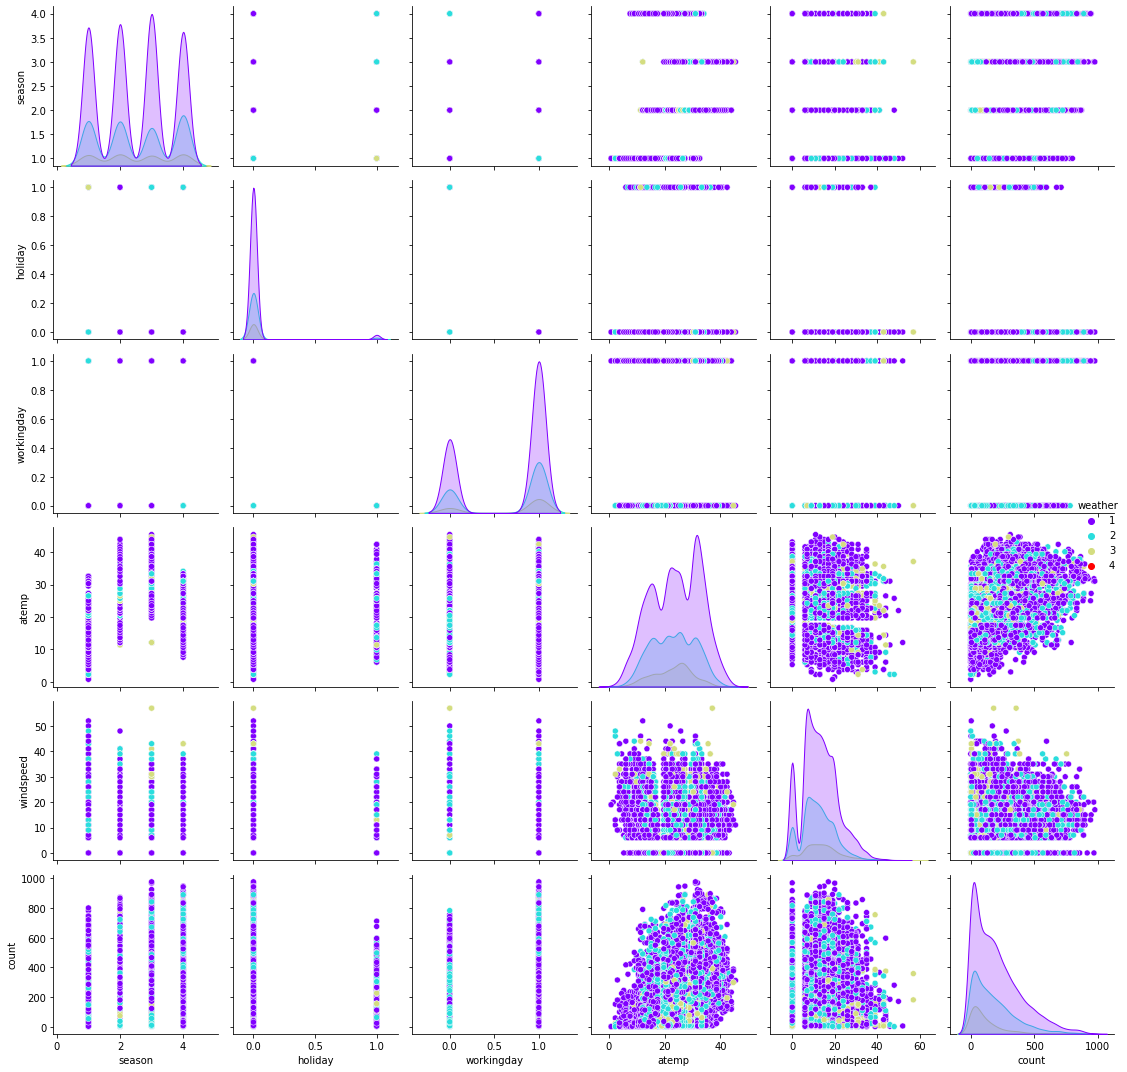

In [14]:
plt.figure(figsize=(8, 6))
sns.pairplot(bike_df[['season', 'holiday', 'workingday', 'atemp', 'windspeed','weather', 'count']], hue='weather', palette = 'rainbow')
plt.tight_layout()
plt.show()

### Data *Preprocessing*

In [86]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


#### Feature Engineering

In [87]:
def bike_feature_engineering(df):
  """
  feature engineering for bike datasets
  1.convert data type of datetime feature into datetime64(# datetime feature - 문자열을 datetime 타입으로 변경)
  2.New feature addition
  3.unnecessary features removal
  """
  # 1.문자열을 datetime 타입으로 변경
  df['datetime'] = df['datetime'].apply(pd.to_datetime)

  # 2.atetime 타입에서 년, 월, 일, 시간 추출
  df['year'] = df['datetime'].apply(lambda x : x.year)
  df['month'] = df['datetime'].apply(lambda x : x.month)
  df['day'] = df['datetime'].apply(lambda x : x.day)
  df['hour'] = df['datetime'].apply(lambda x : x.hour)

  # 3.불필요한 컬럼 삭제 - datetime, casual, registered
  df.drop(columns = ['datetime', 'casual', 'registered'], axis = 1, inplace=True)

  display(df.head(n = 3))
  display(df.info())

In [88]:
# datetime feature - 문자열을 datetime 타입으로 변경. 
# 불필요한 컬럼 삭제 : datetime, causal, registered
bike_feature_engineering(bike_df)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
 9   year        10886 non-null  int64  
 10  month       10886 non-null  int64  
 11  day         10886 non-null  int64  
 12  hour        10886 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 1.1 MB


None

### Predict performance for Regression

#### mean_squared_error,  mean_absolute_error
* 로그변환, 피처인코딩, 모델 학습 /예측/평가

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
  """
  log 값 변환 시 언더플로우 영향으로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
  y - 실제값, pred - 예측값
  """
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)

  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

def rmse(y, pred):
  """
  사이킷런의 mean_squared_error()를 이용하여 rmse계산
  """  
  return np.sqrt(mean_squared_error(y, pred))

#책에서는 meas_absolute_error()를 MSE로 잘못 기재함.
def evaluate_regr(y, pred):
  """
  MAE, RMSE, RMSLE 를 모두 계산 
  """
  rmsle_val = rmsle(y, pred)
  rmse_val  = rmse(y, pred)

  # MAE 는 scikit learn의 mean_absolute_error() 로 계산
  mae_val  = mean_absolute_error(y, pred)
  print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [92]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
def fit_predict_lgr(df, logTrns):
  """
  1.데이터프레임을 받아 피처와 레이블 데이터셋 분리
  2.훈련 및 테스트를 나누어 리턴
  3.로그변환여부 파라미터 추가
  """
  y_target = df['count']
  X_features = df.drop(['count'], axis = 1, inplace=False)
  y_target_log = None
  if logTrns:
    # 타겟 컬럼인 count 값을 log1p 로 Log 변환
    y_target_log = np.log1p(y_target)
    # 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=.3, random_state=0)
  else:
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=.3, random_state=0)

  lr_reg = LinearRegression()
  lr_reg.fit(X_train, y_train)
  pred = lr_reg.predict(X_test)

  # 실제 값에 대한 예측치에 대한 평가를 수행전 로그변환전의 값으로 복구
  y_test_emp = np.expm1(y_test)
  # 예측값또한 변환된 값을 기반으로 예측되었음으로 로그변환전으로 되돌리기
  pred_emp = np.expm1(pred)

  if logTrns:    
    evaluate_regr(y_test_emp, pred_emp)
  else:
    evaluate_regr(y_test, pred)
  return y_test, pred, lr_reg, X_features, y_target_log

def get_top_error_data(y_test, pred, n_tops = 5):
  """
  실제로 대여횟수(count)와 예측한 대여횟수 비교
  """
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['Diff'] = np.abs(result_df['real_count']- result_df['predicted_count'])

  # 예측값과 실제값이 가장 큰 데이터순으로 출력
  display(result_df.sort_values('Diff', ascending=False)[:n_tops])
def main_process(df,  n_tops=5, logTrns=False):
  """
  Fit, predict, log transformation for Regression of Bike Sharing Demand datasets
  df - DataFrame, logTrns - boolean for Log transformation, n_tops = TopN
  """
  y_test , pred, model, X_features, y_target_log = fit_predict_lgr(df,logTrns)
  get_top_error_data(y_test, pred, n_tops)
  return model, X_features, y_target_log

In [93]:
# 대여횟수가 큰 값에 대한 오류가 크게 나오면 RMSE값이 크게 나와서 
# RMSE가 크게 나온것이다.
main_process(bike_df, 20)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


,real_count,predicted_count,Diff
1618,890,322.0,568.0
3151,798,241.0,557.0
966,884,327.0,557.0
412,745,194.0,551.0
2817,856,310.0,546.0
2277,813,267.0,546.0
2314,766,222.0,544.0
454,721,177.0,544.0
1003,713,171.0,542.0
2394,684,142.0,542.0


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
        season  holiday  workingday  weather  ...  year  month  day  hour
 0           1        0           0        1  ...  2011      1    1     0
 1           1        0           0        1  ...  2011      1    1     1
 2           1        0           0        1  ...  2011      1    1     2
 3           1        0           0        1  ...  2011      1    1     3
 4           1        0           0        1  ...  2011      1    1     4
 ...       ...      ...         ...      ...  ...   ...    ...  ...   ...
 10881       4        0           1        1  ...  2012     12   19    19
 10882       4        0           1        1  ...  2012     12   19    20
 10883       4        0           1        1  ...  2012     12   19    21
 10884       4        0           1        1  ...  2012     12   19    22
 10885       4        0           1        1  ...  2012     12   19    23
 
 [10886 rows x 12 columns],


In [94]:
main_process(bike_df, 10)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


,real_count,predicted_count,Diff
1618,890,322.0,568.0
3151,798,241.0,557.0
966,884,327.0,557.0
412,745,194.0,551.0
2817,856,310.0,546.0
2277,813,267.0,546.0
2314,766,222.0,544.0
454,721,177.0,544.0
1003,713,171.0,542.0
2394,684,142.0,542.0


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
        season  holiday  workingday  weather  ...  year  month  day  hour
 0           1        0           0        1  ...  2011      1    1     0
 1           1        0           0        1  ...  2011      1    1     1
 2           1        0           0        1  ...  2011      1    1     2
 3           1        0           0        1  ...  2011      1    1     3
 4           1        0           0        1  ...  2011      1    1     4
 ...       ...      ...         ...      ...  ...   ...    ...  ...   ...
 10881       4        0           1        1  ...  2012     12   19    19
 10882       4        0           1        1  ...  2012     12   19    20
 10883       4        0           1        1  ...  2012     12   19    21
 10884       4        0           1        1  ...  2012     12   19    22
 10885       4        0           1        1  ...  2012     12   19    23
 
 [10886 rows x 12 columns],


**실제값과 예측값의 차이가 큰 경우는 Target값의 분포가 왜곡된 형태를 이루고있는지 확인할것.**
* `count` 타겟값이 `0 ~ 200`사이에 편중되어 있음

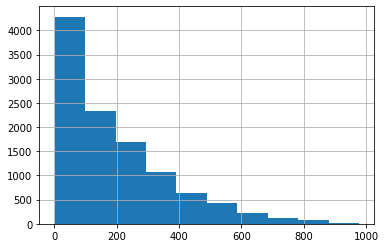

In [95]:
bike_df['count'].hist()

* 로그변환(np.log1p)를 통해 변환 후 분포도 확인

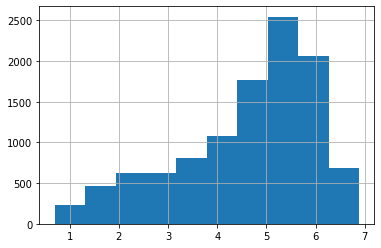

In [96]:
# 정규분포에 조금은 유사하게 분포
y_log_transform = np.log1p(bike_df['count'])
y_log_transform.hist()  

#### Evaluation for Regression afer Log transformation

In [97]:
# 왜곡된 분포를 로그변환 후 학습/예측 및 평가 재수행
# RMSLE 오류는 줄어들었지만, 반대로 RMSE값이 오히려 더 늘어남
lr_reg, X_features, y_target_log = main_process(bike_df, 10,True)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


,real_count,predicted_count,Diff
1521,0.693147,4.0,3.306853
786,0.693147,4.0,3.306853
1242,0.693147,4.0,3.306853
3168,0.693147,4.0,3.306853
3238,0.693147,4.0,3.306853
769,0.693147,4.0,3.306853
2952,0.693147,4.0,3.306853
1086,0.693147,4.0,3.306853
1031,0.693147,4.0,3.306853
2325,0.693147,4.0,3.306853


**Visualization for Regression coefficents**
* RMSE오류가 오히려 늘어서 피처의 회귀계수 확인

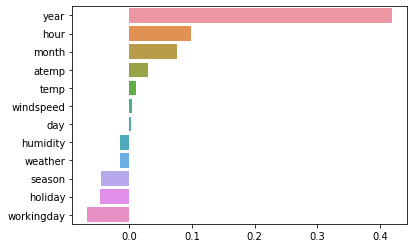

In [98]:
coeff = pd.Series(lr_reg.coef_, index = X_features.columns)
coeff_sort = coeff.sort_values(ascending=False)
sns.barplot(x = coeff_sort.values, y=coeff_sort.index)

* `year` feature is not related to the bike sharing demand.
* categorical feature with number type should be converted using One-Hot Encoding.

In [76]:
def one_hot_encoding(target: list):
  from sklearn.model_selection import train_test_split
  """
  카데고리형 숫자형 데이터 타입에 대한 온핫 인코딩
  """
  X_features_ohe = pd.get_dummies(X_features, columns= target)
  return X_features_ohe

def split_train_test(X_features_ohe, y_target_log):
  """
  온핫인코딩이 적용된 데이터를 기반으로 학습 /테스트 데이터 셋 분할
  """
  X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,\
                                                      test_size=.3, random_state=0)
  return X_train, X_test, y_train, y_test
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  """
  온핫인코딩이 적용된 학습, 테스트 데이터셋트에 대한 학습, 예측 및 로그변환 후 평가점수 
  리턴함.
  """
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1 :
    y_test = np.log1p(y_test)
    pred = np.log1p(pred)
  print('###',model.__class__.__name__,'###')  
  evaluate_regr(y_test, pred)

def main(target, models):
  """
  1.인자로 받은 타겟 컬럼에 대한 원핫인코딩 수행
  2.원핫 인코딩이 수행된 피처에 대한 학습 /테스트 데이터셋 분리후 학습, 예측 및 평가 수행 
  3.추가적으로 옵션정보(is_expm1옵션)에 따라 로그변환 수행
  """
  X_features_ohe = one_hot_encoding(target)
  X_train, X_test, y_train, y_test = split_train_test(X_features_ohe, y_target_log)
  for model in models:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True) 
  
  return X_features_ohe

In [99]:
# 원핫인코딩 피처 대상.
target = ['year','month','hour', 'holiday','workingday','season','weather']

#모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)
models = [lr_reg, ridge_reg, lasso_reg]

X_features_ohe = main(target, models)

### LinearRegression ###
RMSLE: 0.064, RMSE: 0.142, MAE: 0.093
### Ridge ###
RMSLE: 0.064, RMSE: 0.142, MAE: 0.094
### Lasso ###
RMSLE: 0.069, RMSE: 0.153, MAE: 0.102


In [33]:
# 'year','month','hour','season','weather' feature들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','hour', 'holiday',
                                              'workingday','season','weather'])

* **Visualization accoring to coefficent by ascending orgder.**

In [100]:
def visualization_coeff_reg(models, cols, n_tops=10):
  """
  모델별 회귀계수의 높은 피처별로 시각화
  """
  fig, ax = plt.subplots(figsize=(24, 10),nrows = 1, ncols= len(models))
  fig.tight_layout()

  for i, model in enumerate(models):
    ax[i].set_title(model.__class__.__name__+' Coefficient', size=10)
    ax[i].tick_params(axis='y', direction='in', pad=-10)
    coef = pd.Series(model.coef_, index = cols)
    coef_sort = coef.sort_values(ascending=False)[:n_tops]
    for label in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
      label.set_fontsize(10)
    sns.barplot(x=coef_sort, y=coef_sort.index, ax = ax[i])

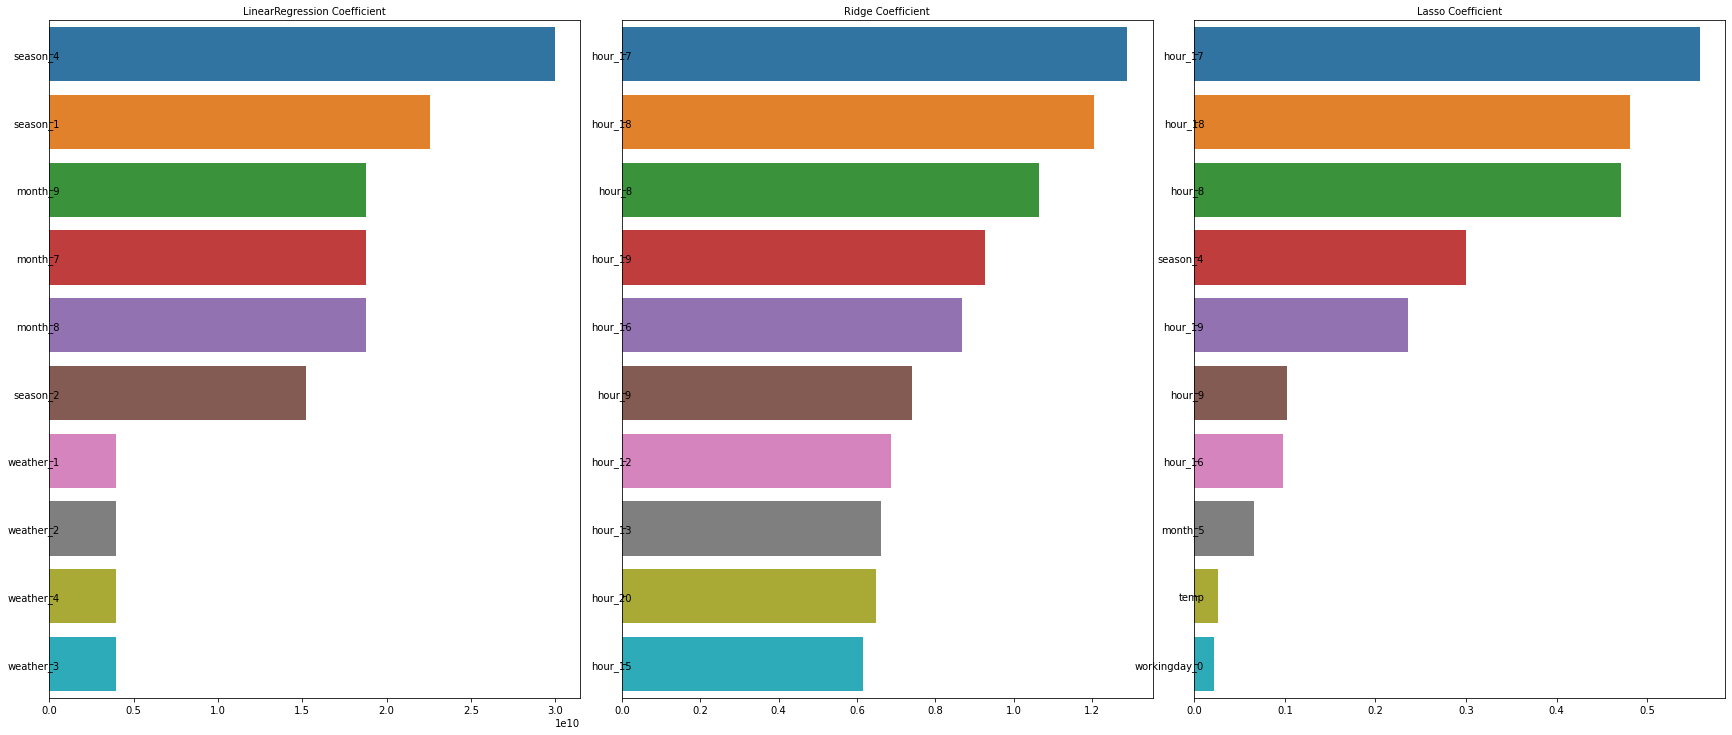

In [73]:
visualization_coeff_reg(models, X_features_ohe.columns, n_tops=10)

* Check by each model.

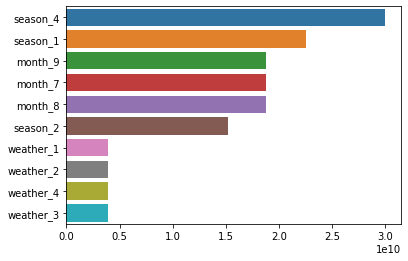

In [101]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

* Process regression prediction using Regression Tree

In [102]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
target = ['year','month','hour', 'holiday','workingday','season','weather']

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

models = [rf_reg, gbm_reg, xgb_reg, lgbm_reg]

main(target, models)

### RandomForestRegressor ###
RMSLE: 0.044, RMSE: 0.093, MAE: 0.054
### GradientBoostingRegressor ###
RMSLE: 0.042, RMSE: 0.089, MAE: 0.054
[14:05:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.043, RMSE: 0.090, MAE: 0.055
### LGBMRegressor ###
RMSLE: 0.041, RMSE: 0.085, MAE: 0.049


,temp,atemp,humidity,windspeed,day,year_2011,year_2012,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,holiday_0,holiday_1,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
1,9.02,13.635,80,0.0000,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
2,9.02,13.635,80,0.0000,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
3,9.84,14.395,75,0.0000,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
4,9.84,14.395,75,0.0000,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,19,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0
10882,14.76,17.425,57,15.0013,19,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0
10883,13.94,15.910,61,15.0013,19,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0
10884,13.94,17.425,61,6.0032,19,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0


### 정리
* 종속값(타겟값)이 정규분포를 이루는 것이 중요
* 코드값에 대한 인코딩은 원핫인코딩을 적용해야 함(pd.get_dummies)